In [1]:
# Загрузка библиотек
import numpy as np # для работы с массивами
import math
import pandas as pd # для работы с DataFrame 
from sklearn import datasets # для импорта данных
import seaborn as sns # для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate
import optuna 
from seqlogo import seqlogo
from itertools import accumulate
import os
from scipy.optimize import nnls
from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfMerger
import shutil
import img2pdf
import plotly.graph_objects as go
import plotly.io as pio
import kaleido.scopes.plotly
import kaleido
import ruptures as rpt
from matplotlib.lines import Line2D

c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Overview

**1-1. Independent variables**\
*Estimated stabilities (dG kcal/mol) within N36-N39 (<span style="background-color: yellow; color: black;">Supplementary Table S3</span>)*

In [2]:
# stability vector based on N37N38 data from Davies 1978 (Supplementary Table S3,S6)
gggD_293 = np.array([0.43, -0.09, -0.04, 0.48, -0.02, -0.30, -0.14, 0.08, -0.83, -1.26,	-1.33, -0.73, -1.03, -1.68,	-1.38, -1.75
])

# stability vector based on N37N38 data from Frechet et al. 1979 (Supplementary Table S6)
gggF_293 = np.array([0.64, -0.54, -1.13, -0.52, -0.45, -0.48, -0.63, -0.78, -1.31, -1.42, -2.04, -1.42, -1.35, -1.99, -2.05, -1.75
])

# stability vector based on averaged stability between the two above ones (Supplementary Table S3,S6)
gggDF_293 = np.array([0.54, -0.32, -0.59, -0.02, -0.24, -0.39, -0.38, -0.35, -1.07, -1.34, -1.68, -1.07, -1.19,	-1.84, -1.72, -1.75
])

**1-2. Dependent variables**\
*Decoding efficiencies calculated as $V_{max}$(+competitor)/Vmax(-competitor) (<span style="background-color: yellow; color: black;">Supplementary Data 1</span>)*

Two sets of decoding efficiencies calculated as Vmax(+competing tRNA)/Vmax(-competing tRNA) for 0.15 uM (V16_015a03) and 0.6 uM (V16_060a03) of competing tRNAArgGCG  (<span style="background-color: yellow; color: black;">Supplementary Data 1</span>)

In [3]:
V16_015a03 = np.array([0.370154292, 0.575912727, 0.715606221, 0.295565821,
                    0.33445206, 0.378950413, 0.485476294, 0.199519987,
                    0.850008374, 0.836215127, 0.893804377, 0.789717291,
                    0.517382229, 0.401054363, 0.59241441,	0.357762808
])

V16_060a03 = np.array([0.125057771, 0.249042673, 0.413830192, 0.093879969,
                    0.112494681, 0.158429256, 0.194482202, 0.057895151,
                    0.60480649, 0.591627439, 0.70972443, 0.488575218,
                    0.196360303, 0.139408676, 0.268791448, 0.118320958
])

# 2. Regression Model Description


The second-order polynomial equation, which forms an overdetermined system of equations for the regression model: 

$\Large{y_{i}=w_{0} + w_{1}\cdot x_i + w_{2}\cdot x_i^2}$

is derived from the equation describing the rate of aa-tRNA selection:   $\Large{\frac{k_{cat}}{K_M}=\frac{k_1}{1+d_1\cdot(1+d_2\cdot(1+d_3))}}$

In the model equation:
* $\Large{x_i=e^{\frac{\Delta G_i}{R\cdot T}}}$ \
where $\Delta G_i$ is the estimated stability within the N37-N39 segment of the respective N37N38 split-tRNA varinat, $R$ and $T$ are the universal gas constant ($\frac{cal}{{mol}\cdotp{K}}$) and temperature ($K$), respectively.

* $\Large{y_i=\frac{(1-f_i)\cdot[c_{split^{Ala}}]}{f_i\cdot[c_{compet^{Arg}}]}}$ \
where $f_i$ denotes the decoding efficincy of the respective N37N38 split-tRNA variant, $c_{split^{Ala}}$ and $c_{compet^{Arg}}$ are the concentrations of the split- and competing tRNAs, respectively.

* $\Large{w_0, w_1, w_2}$ are the regression coefficients where $w_0$ is equal to the discard parameter $d_1$, and $w_1$ and $w_2$ are proportional to the respective discard parameters $d_2$ and $d_3$ 
* index $i$ indicates the respective N37N38 split-tRNA varinat  

# 3. Algorithm Schematic
from Supplementary figure 15

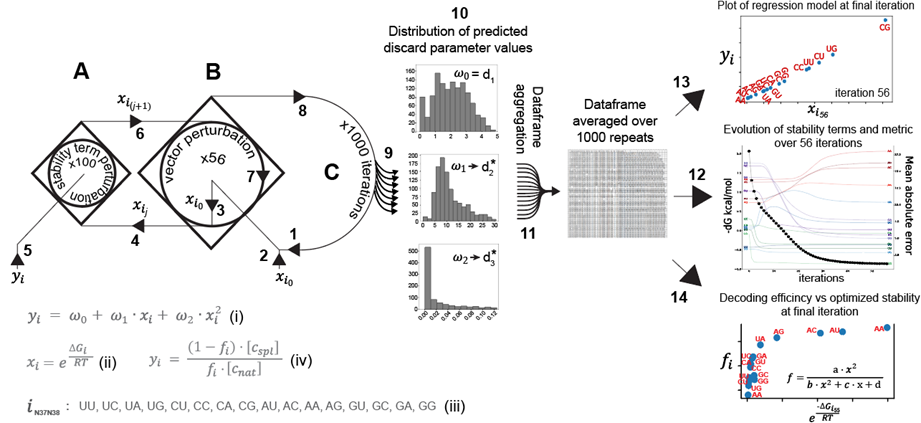

# 4. Main Code Body

### *4-1. Parameter settings*


There are two sets of decoding efficiencies, each corresponding to a different concentration of competing $tRNA^{Arg}GCG$ (a03GCG) that can be fitted to the model independently:

* V16_015a03 corresponding to $0.15\,\mu\text{M}$ of competing $tRNA$
* V16_060a03 corresponding to $0.6\,\mu\text{M}$ of competing $tRNA$

In [4]:
a03GCG = 0.60 # alternatively a03GCG is set to 0.15 uM
if a03GCG == 0.15:
    ratio = 27 
else:
    ratio = 6.7 

f = V16_060a03.copy()
# f = V16_015a03.copy() # when a03GCG is set to 0.6 uM 

# ratio denotes the ratio of concentrations of split- and competing tRNAs

Deriving the vector of dependent variables ($y$), from the vector of decoding efficiencies ($f$) and concentration ratio (see Regression Model Description above):

In [5]:
y =(((1-f)/f)*ratio)-1

Setting the vector of independent variables to one of three vectors that correspond to the alternative stability estimates within the N36-N39 region (refer to the 'Data overview' section):

In [6]:
initial_vector = gggD_293.copy()

In [7]:
degree = 2 # polynimial degree 2 for quadratic equation

### *4-2. Estimating Regression Parameters Corresponding to Initial Free Energy Estimates*

In [8]:
x = np.exp(initial_vector*1.65) # Converting the initial vector of free energy terms in kcal/mol to a vector of reciprocal stability terms (e^(dG/RT)) as required by Eq. 
initial_stabilities = np.exp(-initial_vector*1.65) # # Converting the initial vector of free energy terms in kcal/mol to a vector of stability terms (e^(-dG/RT))
# The adjustment coefficient is calculated as 1.65, equal to 1000/RT, where R = 2 cal/mol*K and T = 303 K 
   
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True) # Creating an object for polynimial features
X_poly = polynomial_features.fit_transform(x.reshape(-1,1)) # expanding the data with polynomial terms to match the quadratic equation format

# Fitting a linear regression model to the polynomial features
initial_coefficients, _ = nnls(X_poly, y) # Obtaining the regression coefficients
y_pred = np.dot(X_poly, initial_coefficients) # Generating the predicted target variables
initial_score = mean_absolute_error(y, y_pred) # Calculating the initial MAE score

initial_stabilities = [round(num,2) for num in initial_stabilities]
initial_coefficients = [round(num,2) for num in initial_coefficients]
initial_score = round(initial_score, 2)

### *4-3. Weight perturbation function (function A in 3)*

In [9]:
def weight_perturbation(vector):
    
    """Random perturbation of stability vector weights"""
    """Running polynomyal regression"""
    """Selection of candidates with the best MAE score"""

    vector_intermed = None
    x = np.exp(vector*1.65) # Converting the vector of free energy terms in kcal/mol to a vector of stability terms (e^(dG/RT))
    # The adjustment coefficient is calculated as 1.65, equal to 1000/RT, where R = 2 cal/mol*K and T = 293 K 
   
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=True) # Creating an object for polynimial features
    X_poly = polynomial_features.fit_transform(x.reshape(-1,1)) # expanding the data with polynomial terms to match the quadratic equation format

    # Fitting a linear regression model to the polynomial features
    coefficients, _ = nnls(X_poly, y) # Obtaining the regression coefficients
    y_pred = np.dot(X_poly, coefficients) # Generating the predicted target variables
    score = mean_absolute_error(y, y_pred) # Calculating the initial MAE score

    for _ in range(100):

        vector_opt = vector.copy()
        integer_range = list(range(16))        # Creating a list of indices from 0 to 15
        random_index = random.choice(integer_range) # Selecting a random index from the list 
        random_float = random.uniform(-1.0, 1.0) # Generating a random float ranging from -1.0 to 1.0
        vector_opt[random_index] += random_float # Updating the weight at a randomly selected index with the generated random float
        x = np.exp(vector_opt*1.65) # Converting the updated stability vector to the exponential form
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=True) # Creating a PolynomialFeatures object
        X_poly = polynomial_features.fit_transform(x.reshape(-1,1))  # Expanding the features with polynomial terms

        # Fitting a linear regression model to the polynomial features
        reg_coefficients, _ = nnls(X_poly, y) # Obtaining the regression coefficients
        y_pred = np.dot(X_poly, reg_coefficients) # Generating the predicted target variables
        intermed_score = mean_absolute_error(y, y_pred) # Calculating the MAE score

        if round(intermed_score, 1) < round(score, 1): 
            score = intermed_score              # Updating the initial score if the new score is lower
            vector_intermed = vector_opt.copy() # Assigning the updated vector_opt to vector_intermed if it corresponds to a lower score
            coefficients = reg_coefficients     # Assigning the regression coefficients corresponding to the best score
    if vector_intermed is not None:
        vector = vector_intermed.copy()   # Reassigning the best vector obtained after 100 random perturbation/selection cycles
    exponentials = np.exp(-vector*1.65)   # Deriving the respective vector of exponential terms

    return score, coefficients, vector, exponentials

### *4-4. Inner cycle ('B' in the schematic in 3) running function A for sequential adjustment of N36-N39 stabilities and outer cycle ('C' in the schematic in 3) repeating the procedure for statistical analysis*
- Inner cycle (Cycle B in Algorithm Schematic) runs 56 sequenctial random adjustments of stability terms by requesting the function A and records the parameters of each adjustment step into a dataframe of 56 rows
- Outer cycle (Cycle C) runs 1000 optimizations , generating 1000 dataframes for statistical analysis.

In [10]:
# Initializing a list to store the dataframes generated over 1000 cycles
df_repeats = []

# Outer cycle C (see Algorithm Schematic above):
for _ in range(1000):
    ini_vector = initial_vector.copy() # Initializing the unperturbed original vector of estimated free energy terms
    cycles_number = 56                 # Number of consecutive random optimizations of free energy terms performed in cycle B, equal to the number of rows in the dataframe
    score_list =[]                     # List of scores obtained for each of the 56 iterations
    coeff_list =[]                     # List of coefficients obtained for each of the 56 iterations
    vector_list = []                   # List of improved free energy terms obtained following each of the 56 iterations
    exponentials_list =[]              # List of respective stability terms

    # Inner Cycle B (see Algorithm Schematic above): 
    for cycle_num in range(cycles_number):
        score, coefficients, vector, exponentials = weight_perturbation(ini_vector) # Calling function A
        # Populating the lists with the parameter values returned through the function call:
        score_list.append(round(score, 2))  
        coeff_list.append([round(num, 2) for num in coefficients])
        vector_list.append([round(num, 2) for num in vector])
        exponentials_list.append([round(num, 2) for num in exponentials])
        ini_vector = vector.copy() # Assigning the updated vector as a new argument to function A for further evolution

    # Creating the dataframe    
    df = pd.DataFrame({'score':score_list, 'coeffs':coeff_list, 'G_terms':vector_list, 'exp_terms':exponentials_list})
    initial_params = {'score':initial_score, 'coeffs':initial_coefficients, 'G_terms':initial_vector, 'exp_terms':initial_stabilities}
    top_row_initial_params = pd.DataFrame([initial_params])
    df = pd.concat([top_row_initial_params, df], ignore_index=True)
    # Appending the dataframe to the list
    df_repeats.append(df)

### *4-5. Reformatting dataframes: extracting discard parameters and adding new features by assigning free energy and stability terms to individual n37n38 variants*

In [11]:
n37n38_list = ['UU', 'UC', 'UA', 'UG', 'CU', 'CC', 'CA', 'CG', 'AU', 'AC', 'AA', 'AG', 'GU', 'GC', 'GA', 'GG']
filtered_list = [] # the list to populte with valid dataframes 
d1_list = []
d1d2_list = []
d2_list = []  # extracting discard parameter d2 from d1*d2
d1d2d3_list = []
d3_list = [] # extracting discard parameter d3 from d1*d2*d3

# Initalizing the counters
l = 0
m = 0
n = 0

# Adding new columns (d1, d1*d2, d1*d2*d3) to each dataframe in the list 
for j, df in enumerate(df_repeats):
    df['d1'] = df['coeffs'].apply(lambda x: x[0])
    df['d1_2'] = df['coeffs'].apply(lambda x: x[1])
    df['d1_2_3'] = df['coeffs'].apply(lambda x: x[2])

# Retriving the last rows corresponding to optimized coefficients from every dataframe 
    d1_last = df['d1'].iloc[-1]
    d1_list.append(d1_last) 
    d1d2_last = df['d1_2'].iloc[-1]
    d1d2_list.append(d1d2_last)
    d1d2d3_last = df['d1_2_3'].iloc[-1]
    d1d2d3_list.append(d1d2d3_last)

# Adding columns corresponding to free energy and stability terms assigned to each individual N37N38 variant     
    for i, n37n38 in enumerate(n37n38_list):
        df[n37n38] = df['G_terms'].apply(lambda x: -x[i])
        df['ex_'+n37n38] = df['exp_terms'].apply(lambda x: x[i]) # 'ex_' marks the stability terms: the exponetials of free energies
    columns = df.columns

# Reordering columns to match the order of N37N38 in the n37n38_list
    dG_columns = [col for col in columns if col in n37n38_list]
    exp_columns = [col for col in columns if col[:3] == 'ex_']
    other_columns = ['score', 'd1', 'd1_2', 'd1_2_3']
    new_columns = other_columns + dG_columns + exp_columns
    df = df[new_columns]

# Evaluating the quality and statistical characteristics of the parameter values to which the model has converged
    # Filtering out 0 values for d1_last and d1d2_last to ensure numerical stability
    if d1_last != 0 and d1d2_last != 0:
        m += 1
        d2_last = d1d2_last / d1_last
        d2_list.append(d2_last)
        d3_last = d1d2d3_last/ d1d2_last
        d3_list.append(d3_last)
    # Filtering out the rare cases that converged to abnormal d3 values
    # Collecting the valid dataframes in the filtered_list
    if d3_last < 10:
        l += 1
        filtered_list.append(df)
    # Determining the proportion of dataframes where d3 converged to less than 0.01 of unity
    if d3_last < 0.01:
        n += 1
        
print(f"The number of dataframes with non-zero coefficients is {m}.\n"
      f"The number of valid dataframes (with d3 < 10) is {l}.\n"
      'The fraction of trials yielding d3 < 0.01 is {}'.format(round(n/len(d3_list), 3))
     )

The number of dataframes with non-zero coefficients is 898.
The number of valid dataframes (with d3 < 10) is 1000.
The fraction of trials yielding d3 < 0.01 is 0.55


### *4-6. Merging and row-wise averaging dataframes*

In [12]:
df_merged = filtered_list[0].copy()
for i in range(1, len(filtered_list)):
    df_merged = df_merged.add(filtered_list[i])

# Averaging
df_averaged = df_merged / len(filtered_list)
# df_final = df_merged.copy()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# display(df_averaged) # Uncomment to display the dataframe

### *4-7. Recollecting individual stability features into a single 'stab_terms' column*

In [13]:
# Create a new column 'MergedColumn' by merging the three columns into lists
df_averaged['stab_terms'] = df_averaged.apply(lambda row: [row['ex_UU'],row['ex_UC'],row['ex_UA'],row['ex_UG'],
                                                         row['ex_CU'],row['ex_CC'],row['ex_CA'],row['ex_CG'],
                                                         row['ex_AU'],row['ex_AC'],row['ex_AA'],row['ex_AG'],
                                                         row['ex_GU'],row['ex_GC'],row['ex_GA'],row['ex_GG']], axis=1)

# Dropping the individual stability features 
df_averaged = df_averaged.drop(['ex_UU','ex_UC','ex_UA','ex_UG',
                            'ex_CU','ex_CC','ex_CA','ex_CG',
                            'ex_AU','ex_AC','ex_AA','ex_AG',
                            'ex_GU','ex_GC','ex_GA','ex_GG'], axis=1)

df_averaged['stab_terms'] = df_averaged['stab_terms'].apply(lambda x: [round(x[i], 3) for i in range(16)]) 

# 5. Visualizing Data and Exporting the Results

### *5-1. Input of user-specified directory path for file export*

In [14]:
# Assign the required directory path to the 'directory' variable
directory = r'C:\your\path\here\end_folder'
# directory = r'C:\Users\mureev\Dropbox\Anticodon_Grafting1\CODE\weights_perturb_av' # example

### *5-2. Visualizing and Exporting the averaged Dataframe*

In [15]:
# Export settings:

# Setting the file name and extension:
file_name = 'averaged_DF.xlsx'

# Generating the full file path
file_path_xls = os.path.join(directory, file_name)

# Exporting the dataframe to Excel file
df_averaged.to_excel(file_path_xls, index=True) # changed df_merged to df_final

# Visualizing the averaged dataframe:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

display(df_averaged)

,score,d1,d1_2,d1_2_3,UU,UC,UA,UG,CU,CC,CA,CG,AU,AC,AA,AG,GU,GC,GA,GG,stab_terms
0,17.79000,17.07000,21.69000,0.00000,-0.43000,0.09000,0.04000,-0.48000,0.02000,0.30000,0.14000,-0.08000,0.83000,1.26000,1.33000,0.73000,1.03000,1.68000,1.38000,1.75000,"[0.49, 1.16, 1.07, 0.45, 1.03, 1.64, 1.26, 0.88, 3.93, 8.0, 8.98, 3.34, 5.47, 15.99, 9.75, 17.95]"
1,13.46377,18.27968,6.84479,5.28235,-0.42969,0.11188,0.04424,-0.48000,-0.00723,0.30000,0.14000,-0.70371,0.83000,1.26000,1.33000,0.73000,1.03000,1.68000,1.38000,1.75000,"[0.49, 1.251, 1.087, 0.45, 0.996, 1.64, 1.26, 0.35, 3.93, 8.0, 8.98, 3.34, 5.47, 15.99, 9.75, 17.95]"
2,11.91070,17.78893,5.11919,5.41881,-0.42704,0.11727,0.12468,-0.48658,-0.25840,0.26057,0.14000,-0.80756,0.83000,1.26000,1.33000,0.73000,1.02406,1.68000,1.38000,1.75000,"[0.493, 1.272, 1.392, 0.446, 0.701, 1.567, 1.26, 0.273, 3.93, 8.0, 8.98, 3.34, 5.441, 15.99, 9.75, 17.95]"
3,11.03478,17.26323,4.98483,5.44274,-0.42420,0.14123,0.32946,-0.49477,-0.37292,0.13112,0.13986,-0.81879,0.83000,1.26000,1.33000,0.73000,0.97551,1.68000,1.38000,1.75000,"[0.496, 1.367, 2.167, 0.441, 0.567, 1.33, 1.26, 0.264, 3.93, 8.0, 8.98, 3.34, 5.216, 15.99, 9.75, 17.95]"
4,10.37843,16.84442,5.27212,5.41478,-0.41762,0.20783,0.54108,-0.50440,-0.41081,0.00844,0.13755,-0.81895,0.83000,1.26000,1.33000,0.73000,0.86529,1.67905,1.38000,1.74805,"[0.502, 1.636, 2.96, 0.435, 0.523, 1.106, 1.256, 0.264, 3.93, 8.0, 8.98, 3.34, 4.698, 15.977, 9.75, 17.921]"
5,9.83940,16.54825,5.49821,5.38689,-0.41132,0.30533,0.68794,-0.51570,-0.42639,-0.07474,0.13139,-0.81836,0.83084,1.26000,1.33000,0.73071,0.67935,1.66867,1.38000,1.73703,"[0.508, 2.011, 3.508, 0.428, 0.505, 0.952, 1.245, 0.264, 3.942, 8.0, 8.98, 3.347, 3.814, 15.839, 9.75, 17.764]"
6,9.37755,16.27075,5.81749,5.30993,-0.40561,0.42980,0.76691,-0.52780,-0.43409,-0.12146,0.12419,-0.81940,0.83342,1.26000,1.33000,0.73411,0.48965,1.64058,1.37907,1.70666,"[0.513, 2.466, 3.822, 0.42, 0.496, 0.865, 1.233, 0.264, 3.972, 8.0, 8.98, 3.39, 2.913, 15.511, 9.742, 17.384]"
7,8.97881,15.86205,6.42765,5.14668,-0.39976,0.50842,0.81852,-0.53777,-0.43862,-0.14782,0.11108,-0.82047,0.84309,1.26000,1.33000,0.75500,0.33845,1.54417,1.37571,1.63979,"[0.519, 2.728, 4.102, 0.414, 0.491, 0.816, 1.211, 0.263, 4.11, 8.0, 8.98, 3.627, 2.203, 14.405, 9.713, 16.49]"
8,8.56283,15.19770,7.36443,4.92425,-0.39597,0.55061,0.85163,-0.54510,-0.44153,-0.16319,0.09921,-0.82104,0.86369,1.26000,1.33000,0.79208,0.24329,1.40095,1.37127,1.51915,"[0.523, 2.862, 4.396, 0.409, 0.488, 0.785, 1.191, 0.263, 4.394, 8.0, 8.98, 4.056, 1.791, 13.065, 9.676, 15.137]"
9,8.14107,14.36096,8.55118,4.64338,-0.39249,0.56936,0.88102,-0.54855,-0.44285,-0.17061,0.09211,-0.82181,0.87841,1.26090,1.33092,0.82863,0.17617,1.23631,1.35912,1.36150,"[0.526, 2.908, 4.68, 0.407, 0.487, 0.771, 1.178, 0.263, 4.597, 8.027, 9.012, 4.49, 1.504, 11.653, 9.569, 13.662]"


### *5-3. Visualizing trends in the Distributions of Discard Parameters and exporting histograms*

*5-3-1. Optimal number of bins calculated using the Freedman-Diaconis rule*

Optimal bin N for d1: 44
Optimal bin N for d1d2: 27
Optimal bin N for d1d2d3: 25
Optimal bin N for d2: 1464
Optimal bin N for d3: 321


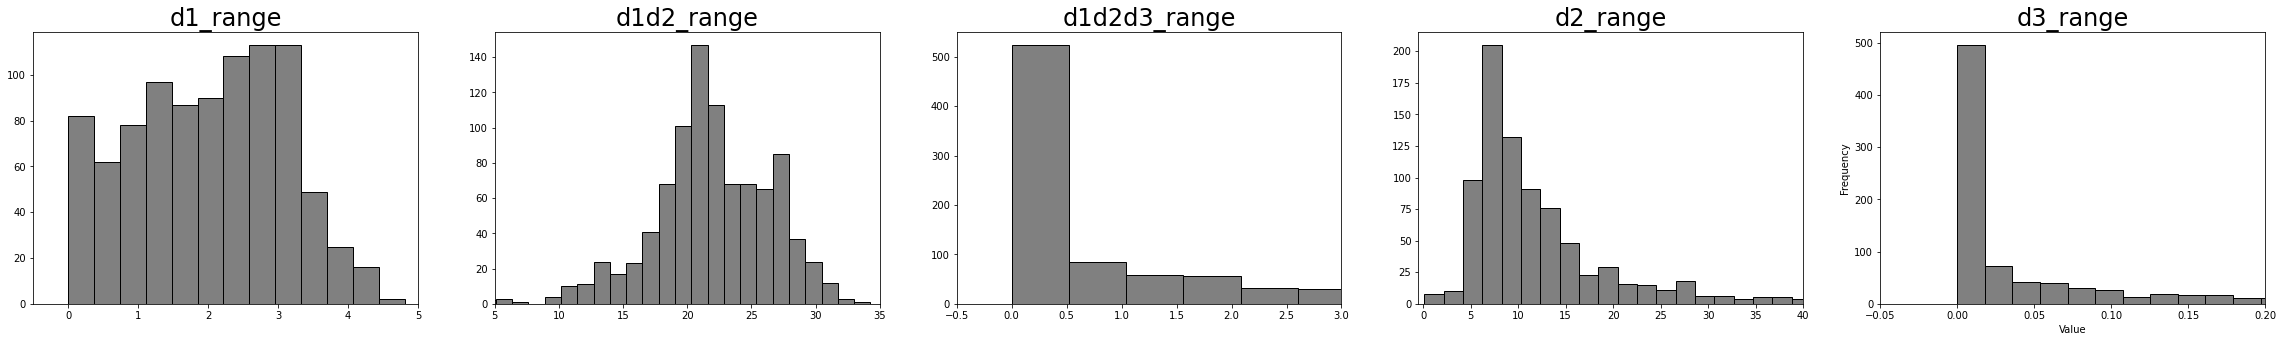

In [16]:
# params for the threshold set < 10:
fig, ax = plt.subplots(1,5, figsize=(40,5))

q25, q75 = np.percentile(d1_list, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(d1_list) ** (1/3))
num_bins = int((max(d1_list) - min(d1_list)) / bin_width)
#######################################################
ax[0].hist(d1_list, bins=num_bins, color='grey', edgecolor='black') # 85, 120, 80!
print('Optimal bin N for d1: {}'.format(num_bins))

q25, q75 = np.percentile(d1d2_list, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(d1d2_list) ** (1/3))
num_bins = int((max(d1d2_list) - min(d1d2_list)) / bin_width)
#######################################################
ax[1].hist(d1d2_list, bins=num_bins, color='grey', edgecolor='black') # 27!
print('Optimal bin N for d1d2: {}'.format(num_bins))

q25, q75 = np.percentile(d1d2d3_list, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(d1d2d3_list) ** (1/3))
num_bins = int((max(d1d2d3_list) - min(d1d2d3_list)) / bin_width)
#######################################################
ax[2].hist(d1d2d3_list, bins=num_bins, color='grey', edgecolor='black') # 200 320, 120!
print('Optimal bin N for d1d2d3: {}'.format(num_bins))

q25, q75 = np.percentile(d2_list, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(d2_list) ** (1/3))
num_bins = int((max(d2_list) - min(d2_list)) / bin_width)
#######################################################
ax[3].hist(d2_list, bins=num_bins, color='grey', edgecolor='black') # 720, 1500, 1680, 2000!
print('Optimal bin N for d2: {}'.format(num_bins))

q25, q75 = np.percentile(d3_list, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(d3_list) ** (1/3))
num_bins = int((max(d3_list) - min(d3_list)) / bin_width)
#######################################################
ax[4].hist(d3_list, bins=num_bins, color='grey', edgecolor='black') # 1500, 350, 1000, 2000!
print('Optimal bin N for d3: {}'.format(num_bins))


ax[0].set_title('d1_range', fontsize=24)
ax[1].set_title('d1d2_range', fontsize=24)
ax[2].set_title('d1d2d3_range', fontsize=24)
ax[3].set_title('d2_range', fontsize=24)
ax[4].set_title('d3_range', fontsize=24)
ax[0].set_xlim(-0.5, 5)
ax[1].set_xlim(5, 35)
ax[2].set_xlim(-0.5, 3)
ax[3].set_xlim(-0.5, 40)
ax[4].set_xlim(-0.05, 0.2)

plt.xlabel('Value')
plt.ylabel('Frequency')

# Setting the file name and extension:
file_name = 'discard_params_distributions.svg'

# Generating the full file path:
file_path = os.path.join(directory, file_name)

# Saving the plot as an .svg file using the specified path
plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0, format = 'svg')

# Displaying the plot 
plt.show()

plt.close()

*5-3-2. Histogram visualization with manually set number of bins*

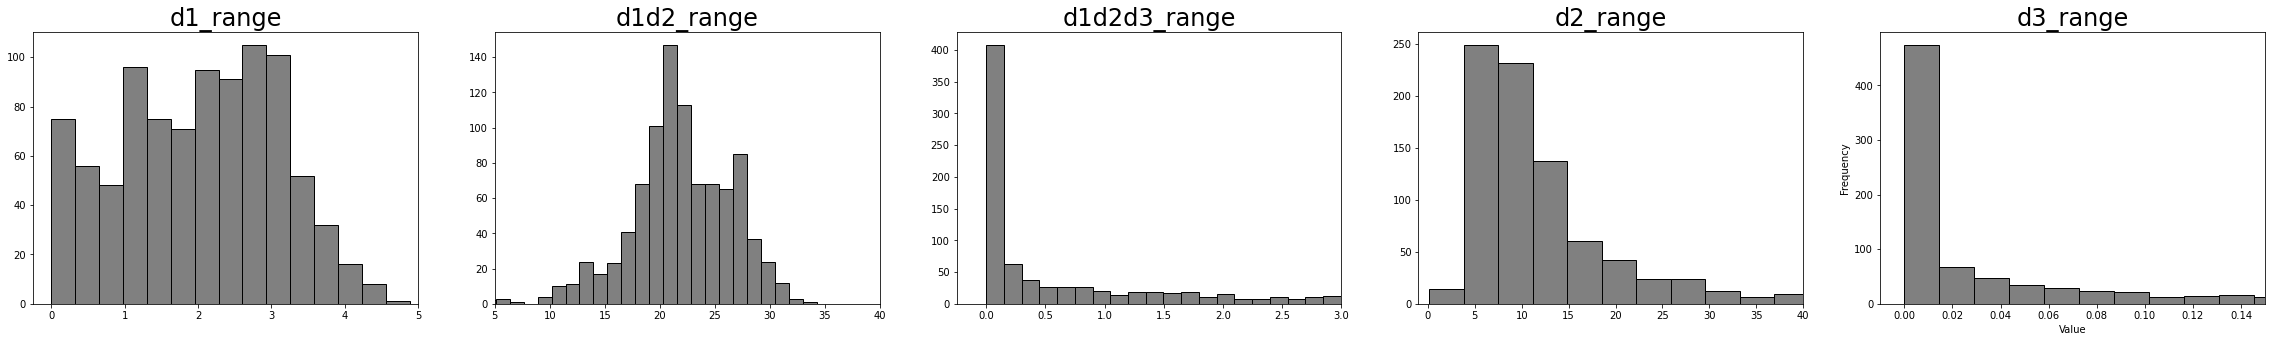

In [17]:
# params for the threshold set < 10:
fig, ax = plt.subplots(1,5, figsize=(40,5))

#######################################################
ax[0].hist(d1_list, bins=50, color='grey', edgecolor='black') # 85, 120, 80!

#######################################################
ax[1].hist(d1d2_list, bins=27, color='grey', edgecolor='black') # 27!

#######################################################
ax[2].hist(d1d2d3_list, bins=87, color='grey', edgecolor='black') # 200 320, 120!

#######################################################
ax[3].hist(d2_list, bins=810, color='grey', edgecolor='black') # 720, 1500, 1680, 2000!

#######################################################
ax[4].hist(d3_list, bins=396, color='grey', edgecolor='black') # 1500, 350, 1000, 2000!


ax[0].set_title('d1_range', fontsize=24)
ax[1].set_title('d1d2_range', fontsize=24)
ax[2].set_title('d1d2d3_range', fontsize=24)
ax[3].set_title('d2_range', fontsize=24)
ax[4].set_title('d3_range', fontsize=24)
ax[0].set_xlim(-0.25, 5)
ax[1].set_xlim(5, 40)
ax[2].set_xlim(-0.25, 3)
ax[3].set_xlim(-1.0, 40)
ax[4].set_xlim(-0.01, 0.15)

plt.xlabel('Value')
plt.ylabel('Frequency')

# # Setting the file name and extension:
# file_name = 'discard_params_distributions.svg'

# # Generating the full file path 
# file_path = os.path.join(directory, file_name)

# # Saving the plot as an .svg file using the specified path
# plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0, format = 'svg')

# Displaying the plot 
plt.show()

plt.close()

### *5-4. Visualizing and exporting the plot on **averaged trends in $\Delta G_{N36-N39}$** as score improves over 56 perturbation cycles*

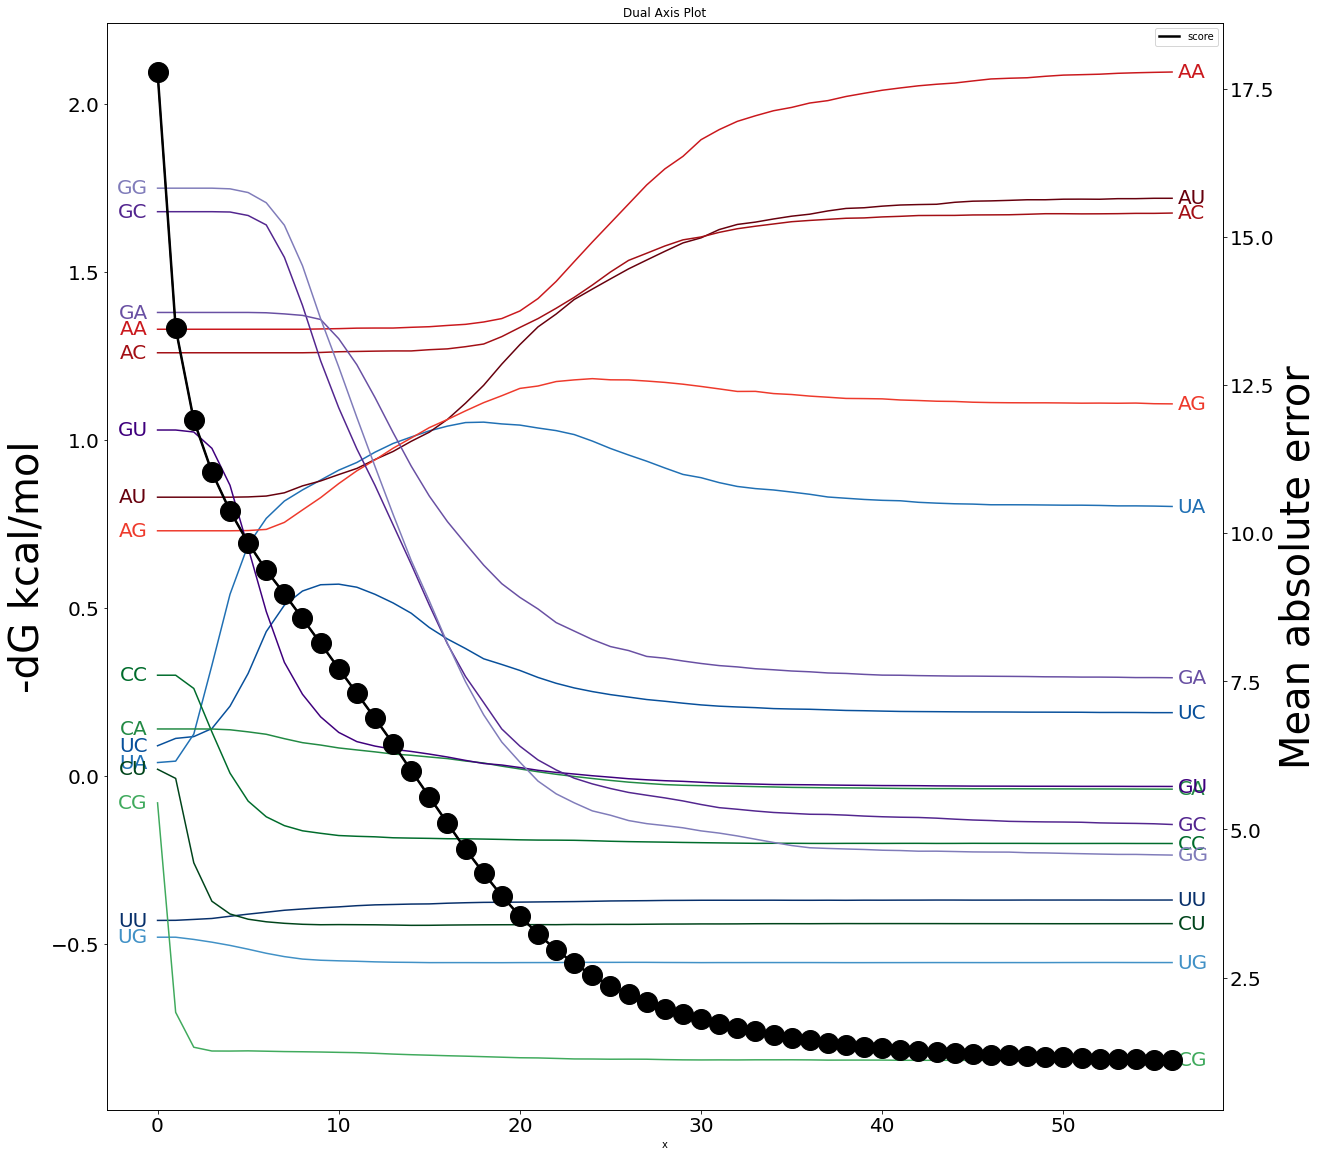

In [18]:
# Create plot
fig, ax1 = plt.subplots(figsize=(20,20))
y1_col_names = ['UU', 'UC', 'UA', 'UG', 'CU', 'CC', 'CA', 'CG', 'AU', 'AC', 'AA', 'AG', 'GU', 'GC', 'GA', 'GG']

# Define 4 main colors
main_colors = ['Blues', 'Greens', 'Reds', 'Purples']
gradient_step = 0.2
# Assign a gradient of colors to each group within the main colors

color_palette = [
    plt.cm.get_cmap(main_colors[i])(1-j/8)
    for i in range(4)
    for j in range(4)
]

lines = []
for i, col_name in enumerate(y1_col_names):
    line, = ax1.plot(df_averaged.index, df_averaged[col_name], label = col_name, linewidth = 1.5, color=color_palette[i])
    lines.append(line)
                 
ax1.set_ylabel('-dG kcal/mol', fontsize=40)

# Mark lines with column names outside the plot area
for line, col_name in zip(lines, y1_col_names):
    y_value = line.get_ydata()[0]
    color = line.get_color()
    ax1.annotate(col_name, xy=(0, y_value), xytext=(-10, 0), textcoords='offset points', ha='right', va='center', fontsize=20, color=color)

# Mark lines with column names on the right side
for line, col_name in zip(lines, y1_col_names):
    y_value = line.get_ydata()[-1]
    color = line.get_color()
    ax1.annotate(col_name, xy=(0, y_value), xytext=(1020, 0), textcoords='offset points', ha='left', va='center', fontsize=20, color=color)

ax2 = ax1.twinx()

line1 = ax2.plot(df_averaged.index, df_averaged['score'], label='score', color='k', linewidth = 2.5)
markers1 = ax2.plot(df_averaged.index, df_averaged['score'], marker='o', color='k', markersize=20, markeredgecolor='k')

ax2.set_ylabel('Mean absolute error', color='k', fontsize=40)

# Increase fontsize for tick labels on all three axes
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# Create the Line2D objects for the legend
line_solid = Line2D([], [], linestyle='-', marker='o', color='black')
line_dotted = Line2D([], [], linestyle=':', marker='o', color='black', markerfacecolor='white')

# Create the legend
legend_elements = [
    line_solid,
    line_dotted
]
labels = ['Solid Line', 'Dotted Line']
plt.legend(legend_elements, labels)

# Set labels and title
ax1.set_xlabel('x')
ax1.set_title('Dual Axis Plot')

# Display the plot
plt.legend()

# Setting the file name and extension:
file_name = 'dG_evolution_score.svg'

# Generating the full file path 
file_path = os.path.join(directory, file_name)

# Saving the plot as an .svg file using the specified path
plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0, format = 'svg')

# Displaying the plot 
plt.show()

plt.close()

### *5-5. Evolution of the relationship between average stability and decoding efficiency over 56 cycles of stability vector optimization: $f(x)$*
$f_i = \Large{\frac{[c_s] \cdot x_i^2}{([c_s] + [c_{wt}] \cdot (1 + d_2^\ast)) \cdot x_i^2 + [c_{wt}] \cdot d_2^\ast \cdot d_3^\ast \cdot x_i + [c_{wt}] \cdot d_1 \cdot d_2^\ast \cdot d_3^\ast}}$


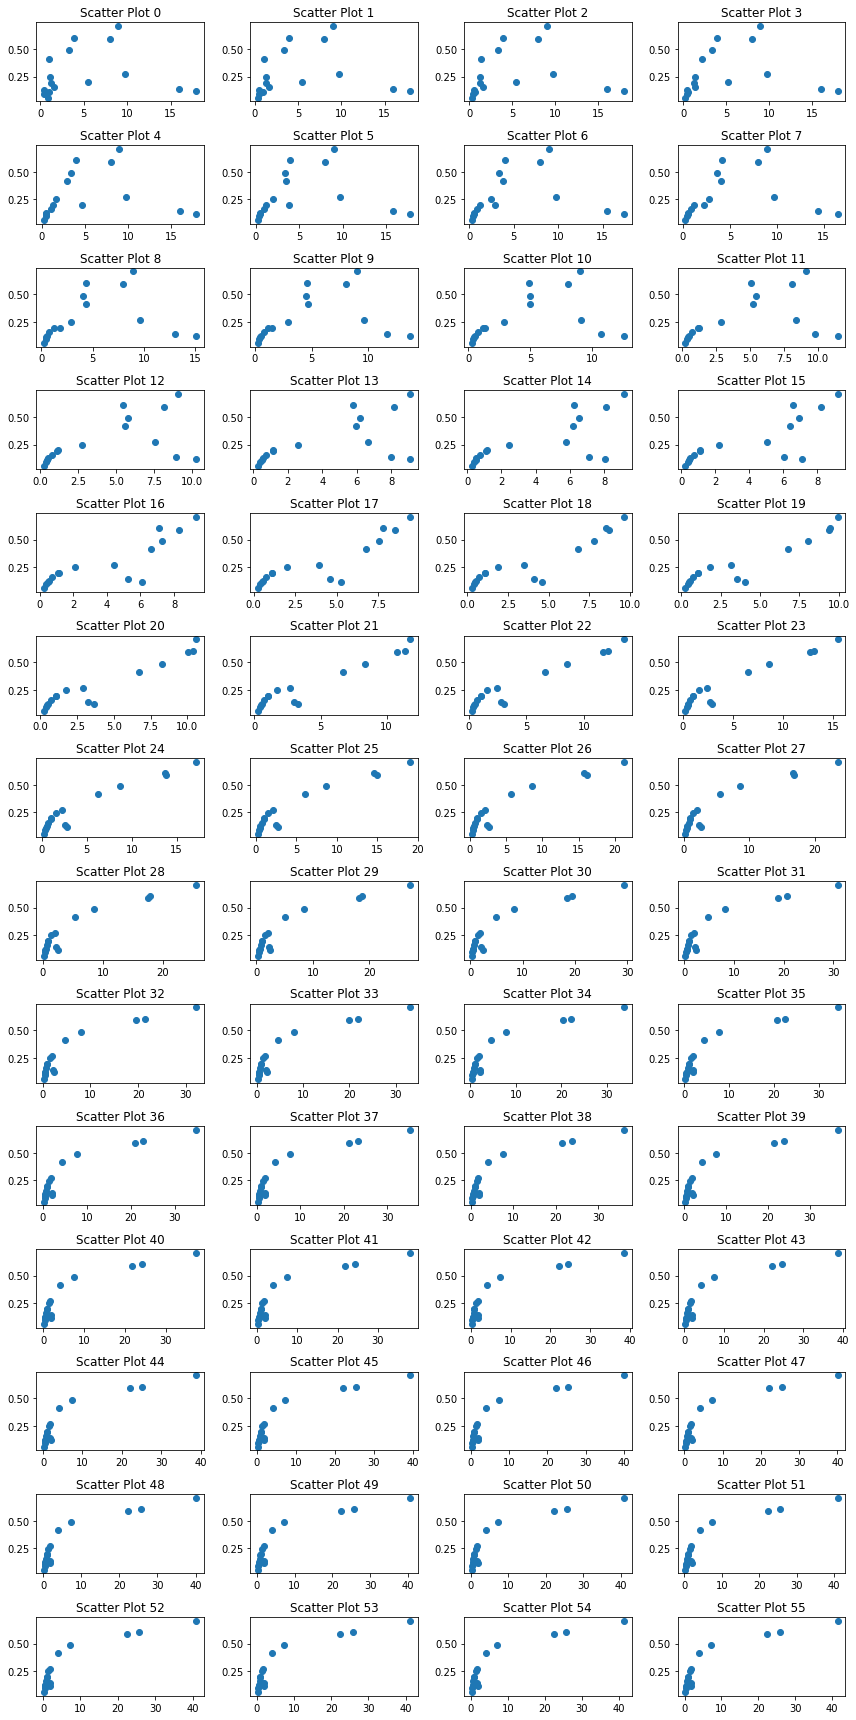

In [19]:
n37n38_list = ['ex_UU', 'ex_UC', 'ex_UA', 'ex_UG', 'ex_CU', 'ex_CC', 'ex_CA', 'ex_CG', 'ex_AU', 'ex_AC', 'ex_AA', 'ex_AG', 'ex_GU', 'ex_GC', 'ex_GA', 'ex_GG']

# Creating the grid of 20 (5x4) subplots for top 20 best vectors
num_rows = round(cycles_number/4)
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 24))

for i, ax in enumerate(axes.flatten()):
    a = df_averaged['stab_terms'][i]
    ax.scatter(a, f)
    ax.set_title(f"Scatter Plot {df_averaged.index[i]}")
    
fig.tight_layout()

# Setting the file name and extension:
file_name = 'fit_evolution.pdf'

# Generating the full file path:
file_path = os.path.join(directory, file_name)

# Saving the plot as an .svg file using the specified path
plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0, format = 'pdf')

# Displaying the plot 
plt.show()

plt.close()

### *5-6. Evolution of the average regression curve over 56 cycles of stability vector optimization: $y(x)$*
$\Large{y_{i}=w_{0} + w_{1}x_i + w_{2}x_i^2}$

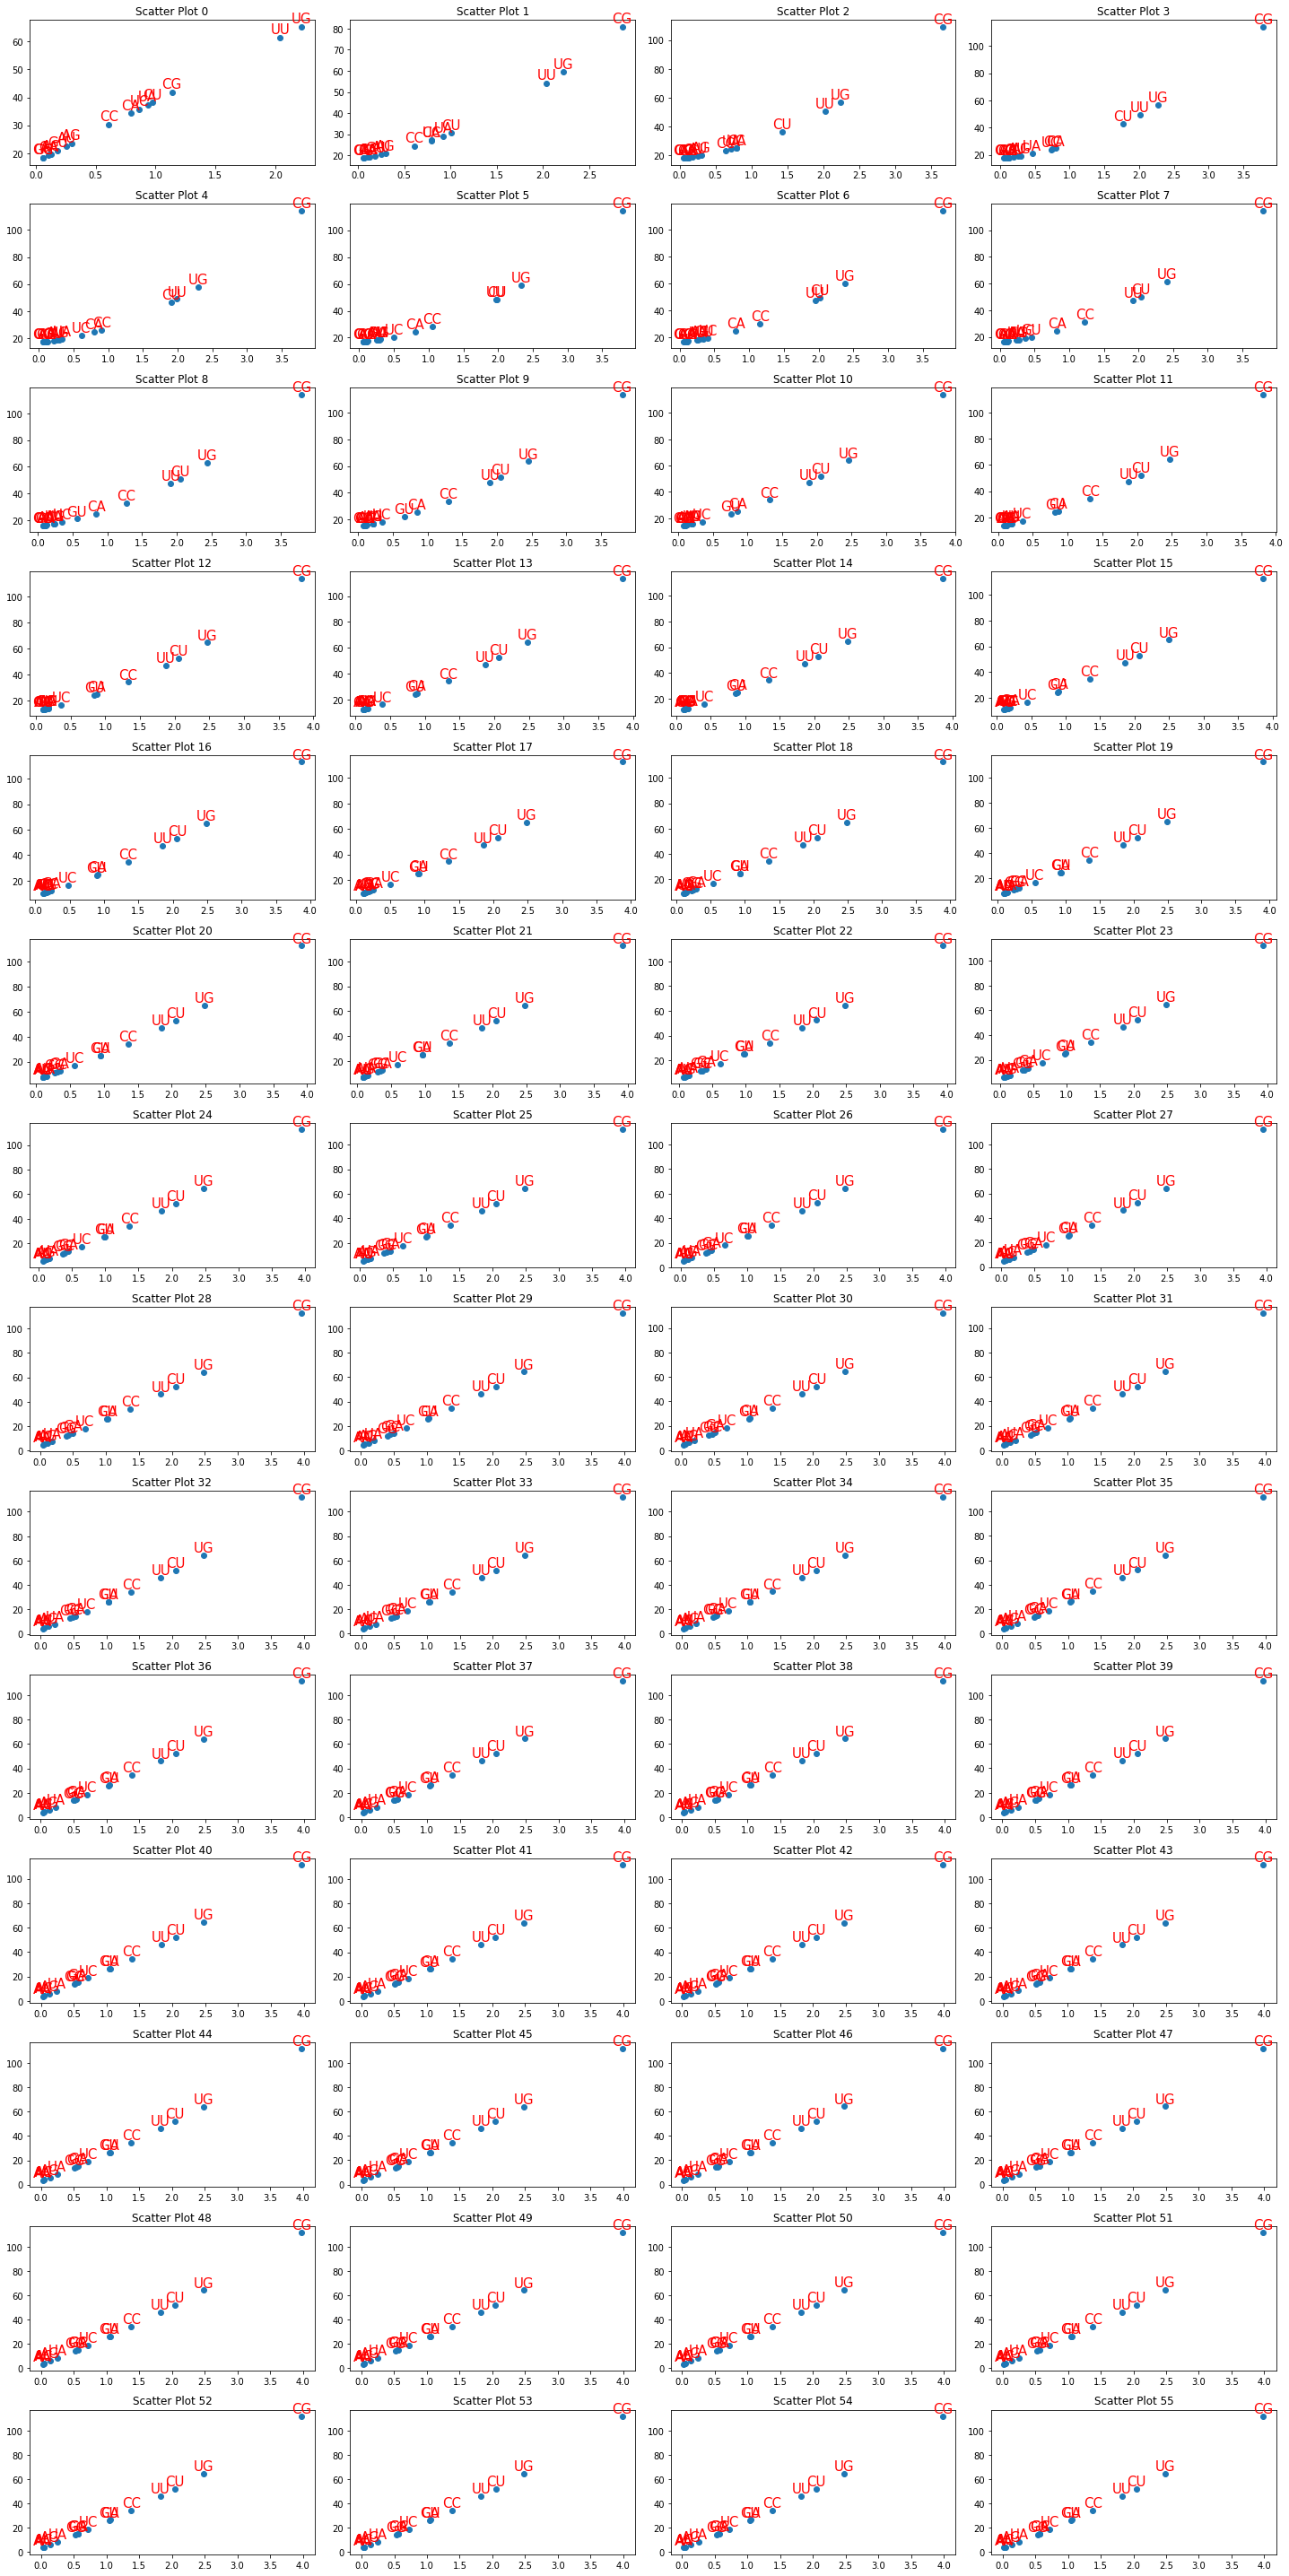

In [20]:
# Creating the grid of 20 (5x4) subplots for top 20 best vectors
labels = ['UU', 'UC', 'UA', 'UG', 'CU', 'CC', 'CA', 'CG', 'AU', 'AC', 'AA', 'AG', 'GU', 'GC', 'GA', 'GG']
w_list = []
num_rows = round(cycles_number/4)
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 40))
#x = np.linspace(0, 20, 100)
for i, ax in enumerate(axes.flatten()):
    x = np.array([(1 / j) for j in df_averaged.loc[i, 'stab_terms']])
    w0 = df_averaged.loc[i, 'd1'] 
    w1 = df_averaged.loc[i, 'd1_2'] 
    w2 = df_averaged.loc[i, 'd1_2_3']  
    y = w0 + w1*x + w2*x**2
    w_list.append([w0,w1,w2])
 
    ax.scatter(x, y)
    ax.set_title(f"Scatter Plot {df_averaged.index[i]}")
    for label, x, y in zip(labels, x, y):
        y_text = y + 0.5
        ax.text(x, y_text, label, color='r', fontsize=15, ha='center', va='bottom')
fig.tight_layout()

# Setting the file name and extension:
file_name = 'regression_plot.pdf'

# Generating the full file path:
file_path = os.path.join(directory, file_name)

# Saving the plot as an .svg file using the specified path
plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0, format = 'pdf')

# Displaying the plot 
plt.show()

plt.close()